In [13]:
from langchain.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings,ChatOllama
from langchain_groq import ChatGroq

from typing import Literal,TypedDict#,Annotated
from pydantic import BaseModel,Field
from enum import Enum
from langgraph.graph import START,END,StateGraph
#from langgraph.prebuilt import ToolNode,tools_condition
from langchain.tools import tool
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage,AIMessage,BaseMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough,RunnableLambda

from langchain_tavily import TavilySearch
from dotenv import load_dotenv

In [2]:
load_dotenv('C:/env/.env')

True

In [ ]:
embeddings=OllamaEmbeddings(base_url='localhost:11434',model='nomic-embed-text')
vectordb = FAISS.load_local('vectordb_4.5',embeddings,allow_dangerous_deserialization=True)
vecdb_retriever = vectordb.as_retriever(search_type="mmr",search_kwargs={'k': 4, 'lambda_mult': 0.9})

@tool
def vectordb_search_tool(query:str):
    '''
    Search on blender 3D software documentation

    Args:
        query: search text string, make sure use the exact blender tools names and keywords for better search.
    '''
    print('--- Vector db search ---')
    return vecdb_retriever.invoke(query)

@tool
def creative_tool(query:str):
    '''
    Look for creative solutions or ideas for a Blender project

    Args:
        query: question related to a Blender 3D project
    '''

    print('--- Creative tool ---')
    prompt_str = "Answer creative solutions or ideas related to a Blender 3D software projec for the question:\n{question}"
    prompt = PromptTemplate(template=prompt_str,input_variables=['question'])
    chain = prompt | llm | StrOutputParser()
    return chain.invoke({'question':query})


@tool
def external_search_tool(query:str):
    '''
    Search the internet

    Args:
        query: search text string for anything, make sure to include blender 3d software in the context
    '''
    print('--- Tavily search ---')
    return tavily_search(query=query,max_results=3)
    

def tavily_search(query,max_results):
    search = TavilySearch(
        max_results=max_results,
        search_depth="advanced",
        #include_answer=True,
        include_raw_content=True
    )
    res = search.invoke(query)
    docs = []
    if 'answer' in res and res['answer'] is not None:
        docs.append(Document(res['answer']))
    for result in res['results']:
        doc = Document(result['content'],metadata={'title':result['title']})
        docs.append(doc)
    return docs


tools = [vectordb_search_tool,creative_tool,external_search_tool]
vector_db_tools = [vectordb_search_tool,creative_tool]
external_search_tools = [external_search_tool]

In [ ]:
external_search_tool.invoke('How to extrude a face in blender?')

In [ ]:
class ContextNodeStruct(BaseModel):
    answer:Literal['yes','no'] = Field(description='Answer if the question is relevant with yes or no')

    #answer:Annotated[Literal['yes','no'],'Answer if the question is relevant with yes or no']
class QuestionStructure(BaseModel):
    new_question:str = Field(description='New rewritten question')
    #new_question:Annotated[str,'New rewritten question']

model_name = 'llama3.1:8b' #'llama-3.1-8b-instant' #'deepseek-r1:8b' #'qwen3:8b'
#simplified_model_name = 'llama3.2:3b'


# llm=ChatGroq(model=model_name)
# llm_deterministic = ChatGroq(model=model_name,temperature=0)
# llm_recommendations = ChatGroq(model=model_name,temperature=1.0)

llm = ChatOllama(base_url='localhost:11434',model=model_name)
llm_deterministic = ChatOllama(base_url='localhost:11434',model=model_name,temperature=0)
llm_recommendations = ChatOllama(base_url='localhost:11434',model=model_name,temperature=1.0)

llm_context_struct = llm_deterministic.with_structured_output(ContextNodeStruct)
llm_new_question_struct = llm.with_structured_output(QuestionStructure)
llm_vdb_tools = llm.bind_tools(vector_db_tools)
llm_external_tools = llm.bind_tools(external_search_tools)


In [ ]:
class SearchState(Enum):
    FIRST_SEARCH=0
    REWRITE_SEARCH=1
    EXTERNAL_SEARCH=2
    END_SEARCH = 3

    def get_next_state(self,allow_external_search):
        inc = 1 if self.value < SearchState.END_SEARCH.value else 0
        next_state = SearchState(self.value+inc)
        if not allow_external_search and next_state == SearchState.EXTERNAL_SEARCH:
            return SearchState.END_SEARCH
        return next_state

class State(TypedDict):
    question:str
    search_query:AIMessage #contains the tool calls list #str
    search_result:list[Document]
    answer:str
    suggestions:str
    search_state:SearchState
    allow_external_search:bool
    session_id:int
    ai_memory:list[BaseMessage]
    is_memory_enabled:bool

memory_history = {}

In [ ]:
def get_ai_memory(session_id):
    global memory_history
    if session_id not in memory_history:
        memory_history[session_id] = []
    return memory_history[session_id]


def get_memory_str(state):
    #dont directly save new question since it may be rewritten by the ai
    if not state['is_memory_enabled']:
        return f"Given the user question:\n{state['question']}"

    labels = {'human':'###Question\n','ai':'###Answer\n'}

    historic = state['ai_memory']
    introduction = "Given the previous questions and answers:\n"
    historic = '\n'.join([f"{labels.get(msg.type,labels['ai'])}{msg.content}" for msg in historic])
    new_question = '\n###New question (in context with the previous messages)\n'+state['question']
    return introduction + historic + new_question

def save_ai_memory(state):
    if state['is_memory_enabled']:
        session_id = state['session_id']
        answer = state['answer'] + '\n' + state['suggestions'] if 'answer' in state else state['suggestions']
        get_ai_memory(session_id).extend( [ HumanMessage( state['question'] ),AIMessage( answer ) ] )

def clean_memory(session_id):
    if session_id in memory_history: 
        del memory_history[session_id]

In [9]:
clean_memory(0)
save_ai_memory({'session_id':0,'question':'What is 1 + 1?','answer':'1 + 1 is 10!','suggestions':'','is_memory_enabled':True})
print(get_ai_memory(0))
print()
print(get_memory_str({'ai_memory':get_ai_memory(0),'question':'Answer in decimal.','is_memory_enabled':True}))

[HumanMessage(content='What is 1 + 1?', additional_kwargs={}, response_metadata={}), AIMessage(content='1 + 1 is 10!\n', additional_kwargs={}, response_metadata={})]

Given the previous questions and answers:
###Question
What is 1 + 1?
###Answer
1 + 1 is 10!

###New question (in context with the previous messages)
Answer in decimal.


In [ ]:
#llm.invoke('Do you know about blender 3D software?')

AIMessage(content="Yes, I'm familiar with Blender 3D software. Blender is a free and open-source 3D creation software that supports various aspects of 3D modeling, animation, rendering, and more.\n\nBlender offers a wide range of features, including:\n\n1. Modeling: Creating 3D models from scratch or importing existing ones.\n2. Sculpting: Shaping and texturing 3D models using various techniques like mesh sculpting or dynamic topology.\n3. Rigging: Setting up skeletal systems for animation and character creation.\n4. Animation: Creating keyframes, easing, and animating characters, objects, and physics simulations.\n5. Rendering: Generating photorealistic images and videos from 3D scenes.\n6. Simulation: Simulating physics, dynamics, and fluid simulations to create realistic effects.\n\nBlender is widely used in various industries, including film, television, video games, architecture, product design, and more. Its strengths lie in its:\n\n* Cross-platform compatibility (Windows, macOS,

In [10]:
def get_initial_state(question,session_id,search_state=SearchState.FIRST_SEARCH,allow_external_search = False,is_memory_enabled=True):
    return {
        'question':question,
        'session_id':session_id if is_memory_enabled else None,
        'search_state':search_state,
        'ai_memory': get_ai_memory(session_id) if is_memory_enabled else None,
        'allow_external_search':allow_external_search,
        'is_memory_enabled':is_memory_enabled
    }

In [11]:
state2 = get_initial_state(question='How to inset a face?',session_id=1)
state2

{'question': 'How to inset a face?',
 'session_id': 1,
 'search_state': <SearchState.FIRST_SEARCH: 0>,
 'ai_memory': [],
 'allow_external_search': False,
 'is_memory_enabled': True}

In [14]:
clean_memory(2)
save_ai_memory({'session_id':2,'question':'How to extrude a face?','answer':'Press E on edit mode!','suggestions':'',
                'is_memory_enabled':True}) 
state2 = get_initial_state('Is there another way?',session_id=2)
state2

{'question': 'Is there another way?',
 'session_id': 2,
 'search_state': <SearchState.FIRST_SEARCH: 0>,
 'ai_memory': [HumanMessage(content='How to extrude a face?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Press E on edit mode!\n', additional_kwargs={}, response_metadata={})],
 'allow_external_search': False,
 'is_memory_enabled': True}

In [12]:
def check_context_condition(state:State) -> Literal['Out of context','Valid context']:
    print('-----check_context_condition-----')
    prompt_msg = (
        "{conversation}\n\n"
        "Answer if the new question is related to the Blender 3D software.\n"
        "Answer only yes or no.")
        
    prompt_template = PromptTemplate(input_variables=['conversation'],template=prompt_msg)
    chain = prompt_template | llm_context_struct
    res = chain.invoke( {'conversation':get_memory_str(state)} )
    return 'Valid context' if res.answer == 'yes' else 'Out of context'

    # prompt_msg = (
    #     'Given the following question: {question}.\n'
    #     'Answer if the question is related to the Blender 3D software.'
    #     'Answer only yes or no.')
    # prompt_template = PromptTemplate(input_variables=['question','historic'],template=prompt_msg)
    # chain = prompt_template | context_struct_llm
    # res = chain.invoke( {'question':state['question']} )
    # #res = chain.invoke( {'question':get_historic_prompt(state)} )
    # return 'Valid context' if res.answer == 'yes' else 'Out of context'

In [13]:
check_context_condition(state2)

-----check_context_condition-----


'Valid context'

In [14]:
def out_of_context_node(state:State):
    print('-----out_of_context_node-----')
    return {'answer':'The question does\'t seems to be related to Blender 3D software. Please make sure to write a consist Blender question.'}

In [15]:
#Allow only vectordb search, but if fails it may try one last time with internet search

def tool_choice_node(state:State):
    print('-----tool_choice_node-----')
    search_state = state['search_state']
    response = None
    if search_state.value <= SearchState.REWRITE_SEARCH.value:
        response = llm_vdb_tools.invoke( get_memory_str(state) )
    elif search_state == SearchState.EXTERNAL_SEARCH and state['allow_external_search']:
        response = llm_external_tools.invoke( get_memory_str(state) )
    return {'search_query':response,'search_state':search_state.get_next_state(state['allow_external_search'])}

In [16]:
res=tool_choice_node(state2)
state2['search_query'] = res['search_query']
state2['search_state'] = res['search_state']
res['search_query'].tool_calls,state2['search_state']

-----tool_choice_node-----


([{'name': 'vectordb_search_tool',
   'args': {'query': 'blender inset face'},
   'id': 'b66b3413-7289-4dd8-be4a-ea68946de685',
   'type': 'tool_call'}],
 <SearchState.REWRITE_SEARCH: 1>)

In [19]:
def retrieve_query_condition(state:State) -> Literal['retriever','recommendation']:
    search_query = state['search_query']
    return 'retriever' if hasattr(search_query,'tool_calls') and len(search_query.tool_calls) > 0 else 'recommendation'    

In [20]:
retrieve_query_condition(state2)

'retriever'

In [21]:
def retrieve_call_node(state:State):
    results = []
    for search_query in state['search_query'].tool_calls:
         for tool in tools:
              if tool.name == search_query['name']:
                    try:
                         res = tool.invoke(search_query['args'])
                         results.extend(res)
                    except Exception as e:
                         print(f"Tool {tool.name} call failed for args {search_query['args']}\n{e}")
                         results.append(Document(page_content='Search failed...'))
               
    return {'search_result':results}

In [22]:
search_result = retrieve_call_node(state2)
state2['search_result'] = search_result['search_result']
search_result

--- Vector db search ---


{'search_result': [Document(id='da576906-658a-4692-be53-21e532626b95', metadata={'source': 'https://docs.blender.org/manual/en/4.5/modeling/meshes/editing/face/extrude_faces.html', 'info': 'Extrude Faces', 'version': '4.5'}, page_content='Extrude Faces¶\n\nReference\n\nMode:\nEdit Mode\n\nMenu:\nFace ‣ Extrude Faces,\nMesh ‣ Extrude ‣ Extrude Faces\n\nShortcut:\nE\n\n\n\nExtrude Faces duplicate faces, while keeping the new geometry connected with the original vertices.\n\n\n\n\n\n\n\nSingle vertex extruded.¶\n\n\n\n\n\n\n\nSingle edge extruded.¶\n\n\n\n\n\n\n\nThis tool is of paramount importance for creating new geometry.\nIt allows you to create parallelepipeds from rectangles and cylinders from circles,\nas well as easily creating such things as tree limbs.\nThe axis on which faces are extruded along can be set interactively.\nFaces are extruded by default along their averaged normal.\nThe extrusion can be limited to a single axis by specifying an axis;\nsee Axis Locking.\nThe extru

In [23]:
import re
def docs_to_str(docs):
    docs_strings = []
    for doc in docs:
        page_content = doc.page_content
        docs_strings.append( re.sub(r'(\s)+',r'\1',page_content) )
    return '\n\n'.join(docs_strings)

In [18]:
#print(docs_to_str(search_result['search_result']))

In [24]:
def rewrite_search_condition(state:State) -> Literal['Generate','Rewrite']:
    # prompt_str = ("Given the question:\n{question}\n"
    # "Answer only yes or no if the answer of the question can be found in the following context:\n{context}\n")
    prompt_str = ("{conversation}\n"
    "Answer only yes or no if the answer of the new question can be found in the following context:\n{context}\n")
    prompt = PromptTemplate(input_variables=['conversation','context'],template=prompt_str)
    chain = (
        {'conversation': RunnablePassthrough(), 'context':RunnableLambda(lambda x: docs_to_str(x['context']))} | 
        prompt | 
        llm_context_struct
        )
    response = chain.invoke( {'conversation':get_memory_str(state),'context':state['search_result']} ).answer

    return 'Generate' if response == 'yes' else 'Rewrite'

In [25]:
rewrite_search_condition(state2)

'Generate'

In [ ]:
def rewrite_node(state:State):
    print('-----rewrite_node-----')
    prompt_str = ("{conversation}\n"
                  "The new question should be related to Blender 3D software. "
                  "Check for semantic intent, meaning and misspelling to formulate an improved question.\n"
                  "Always answer only the new improved question.")
    prompt = PromptTemplate(template=prompt_str,input_variables=['conversation'])
    chain = prompt | llm_new_question_struct | RunnableLambda(lambda x: x.new_question) #| StrOutputParser()
    return {'question': chain.invoke({'conversation':get_memory_str(state)})}

In [27]:
rewrite_node(state2)

-----rewrite_node-----


{'question': 'Can I extrude a face in Blender without switching to edit mode?'}

In [28]:
def answer_node(state:State):
    print('-----answer_node-----')
    prompt_str = (
    "{conversation}\n"
    "Using only the following context:\n"
    "{context}"
    "Answer the new user question:\n"
    )
    prompt = PromptTemplate(input_variables=['context','question'],template=prompt_str)

    chain = {'conversation':RunnablePassthrough(),'context':RunnableLambda(lambda x: docs_to_str(x['context']) ) } | prompt | llm | StrOutputParser()
    response = chain.invoke( {'context':state['search_result'],'conversation':get_memory_str(state)} )
    return {'answer':response}

In [48]:
answer_response = answer_node( state2 )
state2['answer'] = answer_response['answer']

-----answer_node-----


In [49]:
print(answer_response['answer'])

To answer your question, there are two ways to extrude a face: 

1. Press E on edit mode. This method duplicates the selected face while keeping the new geometry connected with the original vertices.

2. Another way is by using Extrude Individual Faces tool. It allows you to extrude a selection of multiple faces as individuals, instead of as a region. The faces are extruded along their own normals, rather than their average.


In [ ]:
from langchain_core.messages import HumanMessage
def recomendations_node(state:State):
    print('-----recomendations_node-----')
    if 'answer' in state:
        prompt_str = ("{conversation}\n"
        "answer: {answer}\n"
        "Answer short related questions or ideas that the user may be interested to search.\n").format(conversation=get_memory_str(state),
                                                                                              answer=state['answer'])
    else:
        prompt_str = ("{conversation}\n"
        "Answer short related suggestions or corrections that the user may be interested to search.\n").format(conversation=get_memory_str(state))
    
    prompt_str += ("Make sure to stay in the context of the Blender 3D software.\n"
                   "Answer only enumareted suggestions WITHOUT answers, the maximun suggestions should be 3.")
    chain = llm_recommendations | StrOutputParser()
    return {'suggestions':chain.invoke( [HumanMessage(prompt_str)] )}

In [64]:
suggestions_res = recomendations_node(state2)
print(suggestions_res['suggestions'])

-----recomendations_node-----
Based on your interest in extruding a face in Blender, here are some related short questions or ideas you may want to explore:

1. How to create a hole in an object using a boolean operation?
2. What is the difference between Edit Mode and Object Mode in Blender?
3. How can I bevel a curve edge in Blender?


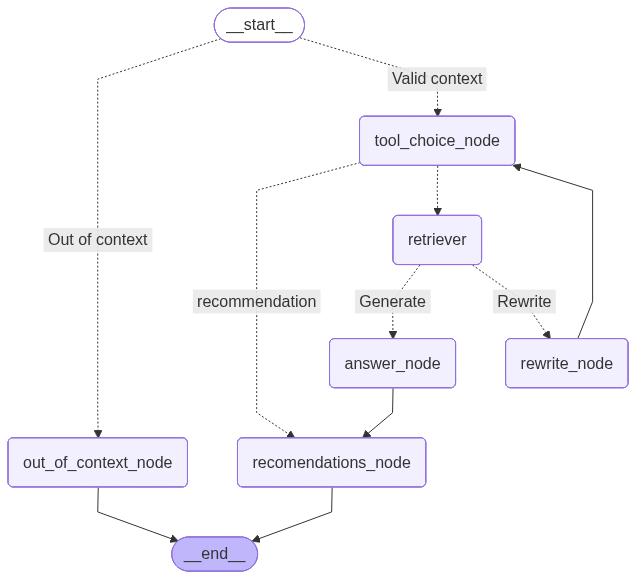

In [65]:
graph = StateGraph(State)

graph.add_node('out_of_context_node',out_of_context_node)
graph.add_node('tool_choice_node',tool_choice_node)
graph.add_node('retriever',retrieve_call_node)
graph.add_node('rewrite_node',rewrite_node)
graph.add_node('answer_node',answer_node)
graph.add_node('recomendations_node',recomendations_node)

graph.add_conditional_edges(START,
                            check_context_condition,
                            {
                                'Out of context':'out_of_context_node',
                                'Valid context':'tool_choice_node'
                            })

graph.add_conditional_edges('tool_choice_node',
                            retrieve_query_condition,
                            {
                                'retriever':'retriever',
                                'recommendation':'recomendations_node'
                            })

graph.add_conditional_edges('retriever',
                            rewrite_search_condition,
                            {
                                'Generate':'answer_node',
                                'Rewrite': 'rewrite_node'
                            }
                            )

graph.add_edge('rewrite_node','tool_choice_node')
graph.add_edge('answer_node','recomendations_node')
graph.add_edge('recomendations_node',END)
graph.add_edge('out_of_context_node',END)
#graph.add_edge('retriever','answer_node')

graph = graph.compile()
graph

In [72]:
initial_state = get_initial_state(question='How to extrude a face?',session_id=99)

In [73]:
final_state = graph.invoke(initial_state)

-----check_context_condition-----
-----tool_choice_node-----
--- Vector db search ---
-----answer_node-----
-----recomendations_node-----


In [74]:
final_state

{'question': 'How to extrude a face?',
 'search_query': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2025-09-04T17:35:27.2004941Z', 'done': True, 'done_reason': 'stop', 'total_duration': 667930000, 'load_duration': 240624000, 'prompt_eval_count': 192, 'prompt_eval_duration': 19767200, 'eval_count': 23, 'eval_duration': 405984100, 'model_name': 'llama3.2:3b'}, id='run--09ed34bc-fdd3-46f6-a0d4-ecbd1acbfddc-0', tool_calls=[{'name': 'vectordb_search_tool', 'args': {'query': 'extrude face blender'}, 'id': 'ad953a36-080d-4575-9cf1-2da779453855', 'type': 'tool_call'}], usage_metadata={'input_tokens': 192, 'output_tokens': 23, 'total_tokens': 215}),
 'search_result': [Document(id='da576906-658a-4692-be53-21e532626b95', metadata={'source': 'https://docs.blender.org/manual/en/4.5/modeling/meshes/editing/face/extrude_faces.html', 'info': 'Extrude Faces', 'version': '4.5'}, page_content='Extrude Faces¶\n\nReference\n\nMode:\nEdit Mode\n\nMen

In [75]:
print(final_state['answer'],'\n\n',final_state['suggestions'])

To extrude a face, you can follow these steps:

1. Select the face you want to extrude.
2. Go to the menu and select "Face" > "Extrude Faces" or press the 'E' key on your keyboard.
3. The extrusion process will begin, and the selected face will be duplicated along with new geometry that is connected to the original vertices.

Note: The extrusion process can be customized by adjusting settings such as the axis of extrusion, whether to flip normals, and more. 

 Here are some related short questions or ideas the user may be interested to search:

1. How to customize extrusion settings in Blender?
2. What is the difference between face and edge extrusion in Blender?
3. Can you combine multiple faces with a single extrusion operation in Blender?


In [76]:
save_ai_memory(final_state)

In [79]:
initial_state = get_initial_state(question='And how can I inset a face?',session_id=99)
final_state = graph.invoke(initial_state)

-----check_context_condition-----
-----tool_choice_node-----
--- Vector db search ---
-----rewrite_node-----
-----tool_choice_node-----
--- Vector db search ---
-----answer_node-----
-----recomendations_node-----


In [80]:
print(final_state['answer'],'\n\n',final_state['suggestions'])

To insert a face in Blender, you need to select two or more vertices and then use Ctrl-RMB click. This will create a planar face, also known as a quad, following the direction of your mouse cursor and using the planar view from your viewport. The extrusion process can be customized by adjusting settings such as the axis of extrusion, whether to flip normals, and more.

Note: If you have three or more vertices selected, Ctrl-RMB click will create planar faces along the vertices selected, following the direction of the cursor. 

 Based on the context of inserting a face in Blender and using Ctrl-RMB click, here are some related short questions or ideas that the user may be interested to search:

1. How do I select multiple vertices in Blender?
2. What is the difference between selecting edges vs. vertices in Blender?
3. Can I create a non-planar surface by selecting multiple edges instead of vertices?


In [82]:
save_ai_memory(final_state)

In [ ]:
initial_state = get_initial_state(question="I didn't mean insert, I mean inset a face.",session_id=99)
final_state = graph.invoke(initial_state)

-----check_context_condition-----
-----tool_choice_node-----
--- Vector db search ---
-----answer_node-----
-----recomendations_node-----


In [86]:
print(final_state['answer'],'\n\n',final_state['suggestions'])

To inset a face in Blender, select two or more vertices and then use Ctrl-RMB click. This will create a planar face, also known as a quad, following the direction of your mouse cursor and using the planar view from your viewport. The extrusion process can be customized by adjusting settings such as the axis of extrusion, whether to flip normals, and more.

Note: If you have three or more vertices selected, Ctrl-RMB click will create planar faces along the vertices selected, following the direction of the cursor. 

 Based on the context of insetting a face in Blender and using Ctrl-RMB click, here are some related short questions or ideas that the user may be interested to search:

1. How do I select multiple edges in Blender?
2. What is the difference between selecting edges vs. faces/vertices in Blender when it comes to insetting/extruding operations?
3. Can I customize the size of the insetted face using Blender's tools?


In [87]:
initial_state = get_initial_state(question="How to inset a face?",session_id=101)
final_state = graph.invoke(initial_state)

-----check_context_condition-----
-----tool_choice_node-----
--- Vector db search ---
-----rewrite_node-----
-----tool_choice_node-----
--- Vector db search ---
-----answer_node-----
-----recomendations_node-----


In [88]:
final_state

{'question': 'How can I insert a face in Blender using the 3D modeling tools?',
 'search_query': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2025-09-04T17:42:28.8543862Z', 'done': True, 'done_reason': 'stop', 'total_duration': 534427200, 'load_duration': 210174400, 'prompt_eval_count': 201, 'prompt_eval_duration': 11693800, 'eval_count': 27, 'eval_duration': 311366400, 'model_name': 'llama3.2:3b'}, id='run--80d43b90-426f-4045-8524-cddc7a95b91d-0', tool_calls=[{'name': 'vectordb_search_tool', 'args': {'query': 'insert face blender 3D modeling tools'}, 'id': 'afe9f00c-d9a5-4292-97d4-aae7de3413f8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 27, 'total_tokens': 228}),
 'search_result': [Document(id='b443a1fb-09ff-4178-81b9-002fc4e35c95', metadata={'source': 'https://docs.blender.org/manual/en/4.5/sculpt_paint/sculpting/editing/face_sets.html', 'info': 'Face Sets', 'version': '4.5'}, page_content='Gr

In [90]:
initial_state = get_initial_state(question='How to cook rice?',session_id=99)
final_state = graph.invoke(initial_state)

-----check_context_condition-----
-----out_of_context_node-----
